In [2]:
from pathlib import Path
import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from topex import Topex

In [27]:
work_dir = Path().cwd() 
dem_path = work_dir / 'data/LX_DEM_50m_res.tif'
src = rio.open(dem_path)
dem = src.read(1)
profile = src.profile
# If DEM contains sea, and land area doesn't have 0m values, we can use this
# masking to remove topex effect on the water areas
land_mask = dem==0.
sea_mask = ~land_mask

In [28]:
def _find_resolution(src):
    assert src.crs, 'Missing or invalid CRS'
    
    if src.crs.is_geographic:
        R = 6_371_000  # m (Average Earth radius)
        DEGREE_LENGTH = 2 * np.pi * R / 360
        # image res in meters
        return abs(src.meta['transform'][4]) * DEGREE_LENGTH
    elif src.crs.is_projected:
        return abs(src.meta['transform'][4])

In [32]:
R = 6_371_000  # m (Average Earth radius)
DEGREE_LENGTH = 2 * np.pi * R / 360 
# image res in meters
src.crs
# NOTE: we assume the DEM .tif file is in WGS CRS, not projected
#       And we assume that the pixel resolution on both directions are same

CRS.from_epsg(4326)

In [31]:
# Define input variables for Topex model
max_distance = 2000 # meters. The farthest distance to calculate the max slope. Initial version was 2000m
interval = 100 # meters. The intervals to iteretively chekc for max slope angle
pixel_spacing = src.meta['transform'][4] * DEGREE_LENGTH # image res in meters

In [18]:
topex = Topex(dem, max_distance, interval, pixel_spacing)
topex_all = topex.all_dir_multip() # multiproc w/o shared_memory
topex_name = ['TOPEX_N', 'TOPEX_NE', 'TOPEX_E', 'TOPEX_SE', 'TOPEX_S', 'TOPEX_SW', 'TOPEX_W', 'TOPEX_NW']

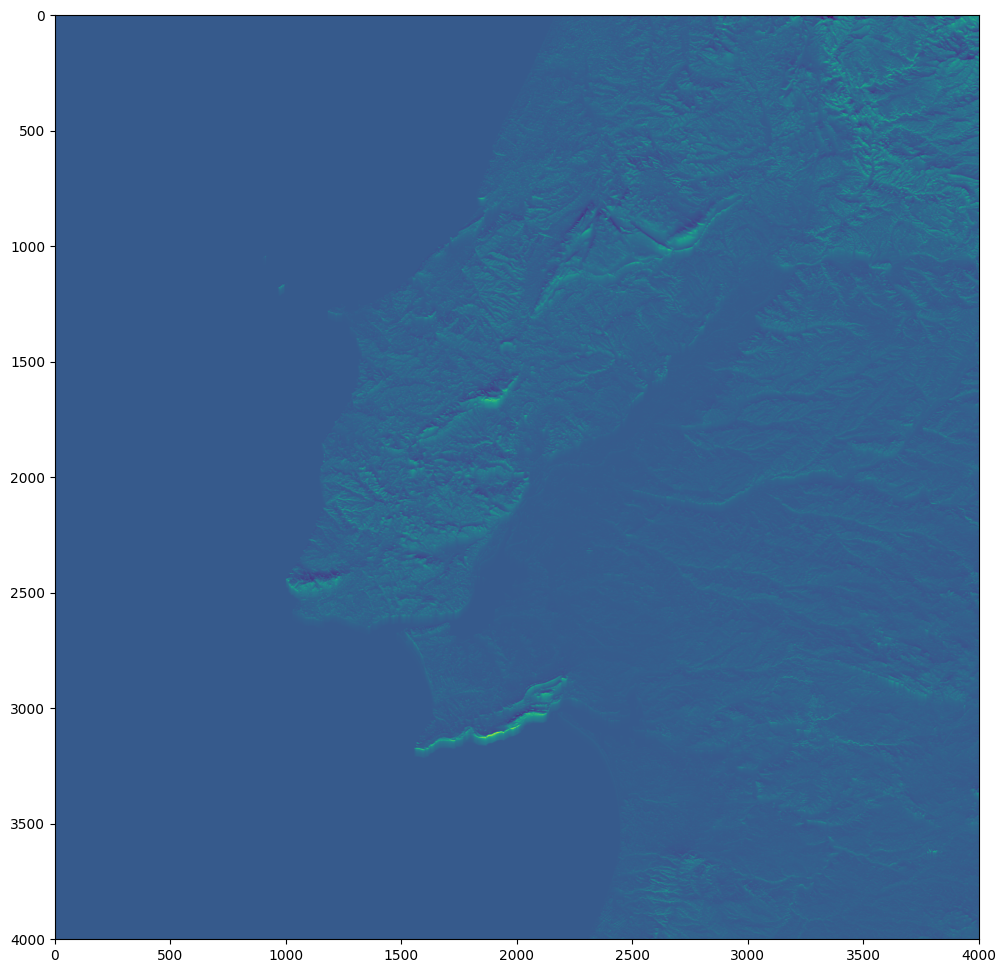

In [19]:
plt.figure(figsize=(12,12))
plt.imshow(topex_all[0])

In [11]:
# Write each TOPEX map in a separate .tif file
profile.update(dtype=rio.float32, count=1)

for topex, name in zip(topex_all, topex_name):
    with rio.open(work_dir / 'data' / f'{name}.tif', 'w', **profile) as dest:
        topex *= sea_mask # Apply sea mask to clean the artifacts
        dest.write(topex, 1) 